In [ ]:
#|default_exp init_zero

# Initialization

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.mps import *
from miniai.utils import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'
import logging
logging.disable(logging.WARNING)

set_seed(42)


In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
xmean,xstd = 0.28, 0.35
bs=1024

In [ ]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
tds = cache_dataset_as_dict(tds)

In [ ]:
dls = DataLoaders.from_dd(tds, bs, num_workers=0)
xb,yb = next(iter(dls.train))

In [ ]:
xb.mean(),xb.std()

(tensor(0.02), tensor(1.01))

In [ ]:
from miniai.init import GeneralRelu, plot_func, init_weights

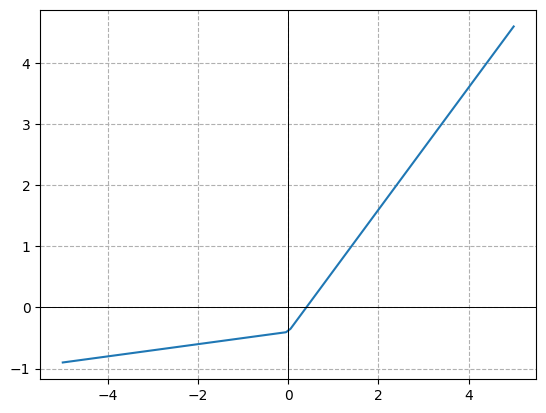

In [ ]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [ ]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

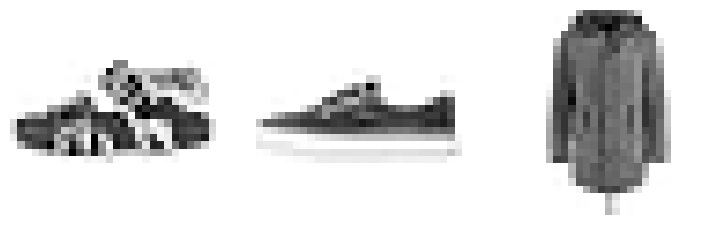

In [ ]:
show_images(-xb[:3])

In [ ]:
xb.shape

torch.Size([1024, 1, 28, 28])

In [ ]:
xb=xb.to('mps')

In [ ]:
m=get_model()
m

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
a = m[0](xb)
a.shape

torch.Size([1024, 8, 14, 14])

In [ ]:
a = m[1](a)
a.shape

torch.Size([1024, 16, 7, 7])

In [ ]:
a = m[2](a)
a.shape

torch.Size([1024, 32, 4, 4])

In [ ]:
a = m[3](a)
a.shape

torch.Size([1024, 64, 2, 2])

In [ ]:
a = m[4](a)
a.shape

torch.Size([1024, 10, 1, 1])

In [ ]:
nn.Sequential.forward??

In [ ]:
from miniai.augment import *

In [ ]:

reseed = ReseedCB()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance((GeneralRelu, nn.ReLU, nn.GELU)))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, reseed]
iw = partial(init_weights, leaky=0.1)

New seed: 205811062
Using seed 205811062


accuracy,loss,epoch,train
0.773,0.643,0,train
0.847,0.415,0,eval


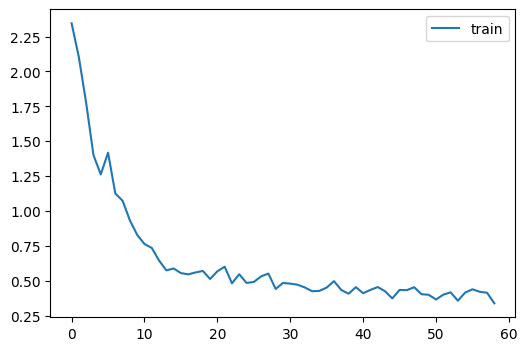

In [ ]:
reseed.previous()
model = get_model(act_gr).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

Using seed 42


accuracy,loss,epoch,train
0.563,1.216,0,train
0.795,0.547,0,eval
0.833,0.449,1,train
0.849,0.415,1,eval
0.864,0.370,2,train
0.859,0.389,2,eval


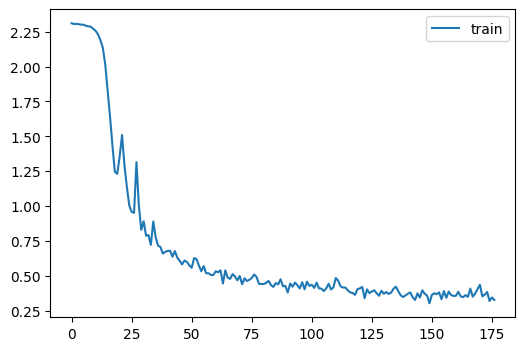

In [ ]:
reseed.set_seed(42)
model = get_model(act_gr)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

Using seed 42


accuracy,loss,epoch,train
0.761,0.659,0,train
0.843,0.430,0,eval
0.868,0.362,1,train
0.859,0.390,1,eval
0.883,0.320,2,train
0.869,0.364,2,eval


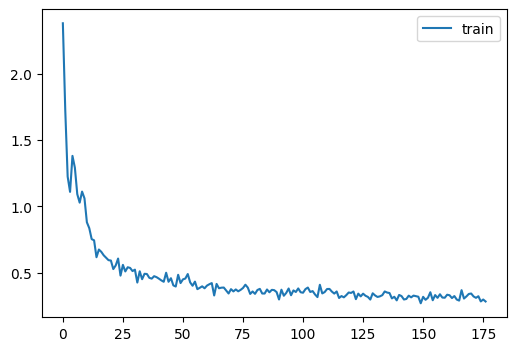

In [ ]:
reseed.set_seed(42)
model = get_model(act_gr).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

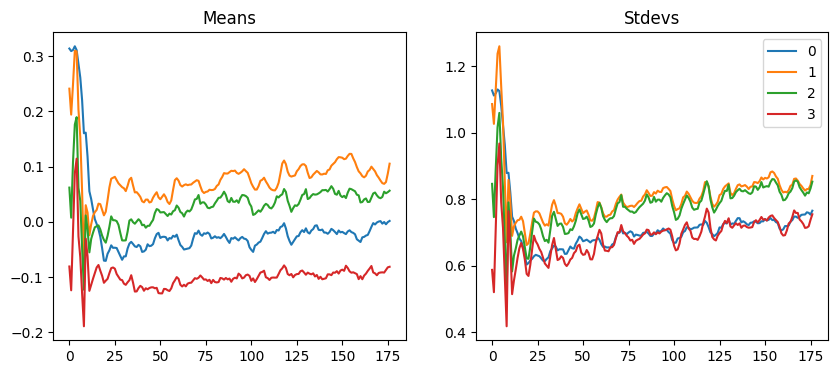

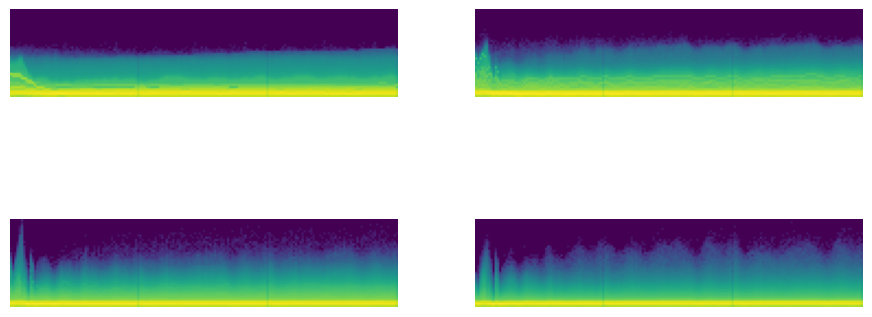

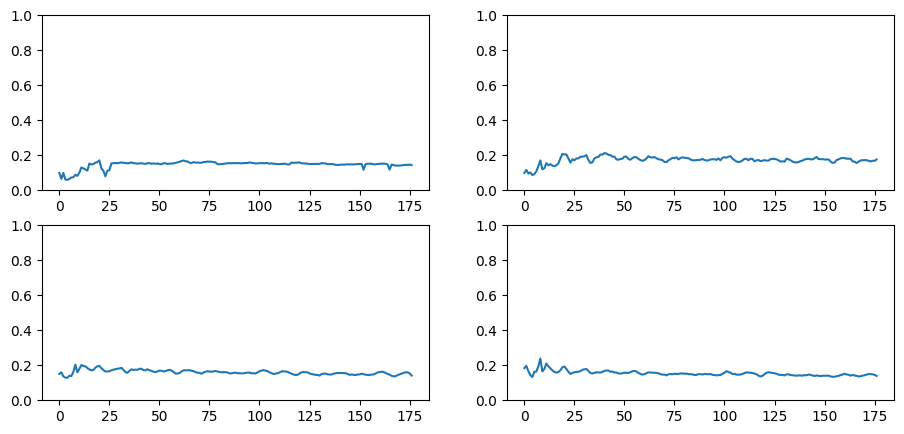

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

## ZerO

In [ ]:
x  = torch.randn(1,10)
t = torch.cat([torch.eye(10,10), torch.zeros(10,5)], dim=1)

print(t)
x@t


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])


tensor([[ 2.21, -0.64,  0.46,  0.27,  0.53,  0.81,  1.11, -1.69, -0.99,  0.96,  0.00,  0.00,  0.00,  0.00,  0.00]])

In [ ]:
x  = torch.randn(1,10)
t = torch.cat([torch.eye(4,4), torch.zeros(4,6)], dim=1).T
t1 = torch.cat([torch.eye(4,4), torch.zeros(6,4)])
assert (t1 == t).all()
print(t)
x@t

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


tensor([[ 1.32,  0.82, -0.77, -0.75]])

In [ ]:
torch.eye(10,4), torch.eye(10,15)

(tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]))

### Identity init

In [ ]:
@torch.no_grad()
def init_identity_(w):
    if w.dim() == 2:
        ## nn.init.eye_ doesn't work on mps for tensor views 
        w.copy_(torch.eye(*w.shape, dtype=w.dtype))
    elif w.dim() == 4:
        n = int(w.shape[-1]/2)
        nn.init.zeros_(w)
        init_identity_(w[...,n,n])
        #w.copy_(torch.eye(*w.shape[2:]))
    else:
        raise NotImplemented('not impl yet')
    return w

In [ ]:
w=init_identity_(torch.randn(2,2,3,3).to(def_device))[...,1,1]
print(w)
assert w.sum() == 2, "init does not work correctly see above"

tensor([[1., 0.],
        [0., 1.]], device='mps:0')


/opt/homebrew/Caskroom/mambaforge/base/envs/miniai/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


In [ ]:
x = torch.rand(1,10)
x

tensor([[0.51, 0.16, 0.08, 0.22, 0.06, 0.18, 1.00, 0.59, 0.65, 0.03]])

In [ ]:
w = torch.rand(10, 6)
init_identity_(w)
w, (x@w)

(tensor([[1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
 tensor([[0.51, 0.16, 0.08, 0.22, 0.06, 0.18]]))

### indentity on convolutions

In [ ]:
idconv = nn.Conv2d(10,10, 1, bias=False)
init_identity_(idconv.weight)
idconv.weight.shape

torch.Size([10, 10, 1, 1])

In [ ]:
x = torch.randn(5,5)[None]
x = torch.cat([x]*10)[None]

In [ ]:
x.shape, x[0,0]

(torch.Size([1, 10, 5, 5]),
 tensor([[-2.58, -0.02, -0.12, -0.75,  1.71],
         [ 0.06,  0.86, -0.59,  0.73, -0.61],
         [-0.56, -0.97,  0.87, -0.10,  0.40],
         [-0.71,  0.83, -0.67,  1.07, -0.25],
         [-0.19, -0.77,  0.18, -2.13, -0.13]]))

In [ ]:
idconv(x)[0,0]

tensor([[-2.58, -0.02, -0.12, -0.75,  1.71],
        [ 0.06,  0.86, -0.59,  0.73, -0.61],
        [-0.56, -0.97,  0.87, -0.10,  0.40],
        [-0.71,  0.83, -0.67,  1.07, -0.25],
        [-0.19, -0.77,  0.18, -2.13, -0.13]], grad_fn=<SelectBackward0>)

In [ ]:
test_close(idconv(x), x)

In [ ]:
conv??

In [ ]:
idconv = nn.Conv2d(10,10, 3, bias=False, padding=3//2)
init_identity_(idconv.weight)
idconv.weight.shape

torch.Size([10, 10, 3, 3])

In [ ]:
test_close(idconv(x), x)

## ZerO init for conv networks

In [ ]:
def hadamard(m):
    if m == 0:
        return torch.eye(1,1)
    else:
        hm_1 = hadamard(m-1)
        return torch.cat([torch.cat([hm_1, hm_1]), torch.cat([hm_1, -hm_1])], dim=1)
hadamard(3)

tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1., -1.,  1., -1.,  1., -1.,  1., -1.],
        [ 1.,  1., -1., -1.,  1.,  1., -1., -1.],
        [ 1., -1., -1.,  1.,  1., -1., -1.,  1.],
        [ 1.,  1.,  1.,  1., -1., -1., -1., -1.],
        [ 1., -1.,  1., -1., -1.,  1., -1.,  1.],
        [ 1.,  1., -1., -1., -1., -1.,  1.,  1.],
        [ 1., -1., -1.,  1., -1.,  1.,  1., -1.]])

In [ ]:
def hadamard(rank, dtype=None):
    H = torch.tensor([[1.]], dtype=dtype)
    for i in range(0, rank): H =  torch.cat([torch.cat([H, H]), torch.cat([H, -H])], dim=1)
    return H
hadamard(3)

tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1., -1.,  1., -1.,  1., -1.,  1., -1.],
        [ 1.,  1., -1., -1.,  1.,  1., -1., -1.],
        [ 1., -1., -1.,  1.,  1., -1., -1.,  1.],
        [ 1.,  1.,  1.,  1., -1., -1., -1., -1.],
        [ 1., -1.,  1., -1., -1.,  1., -1.,  1.],
        [ 1.,  1., -1., -1., -1., -1.,  1.,  1.],
        [ 1., -1., -1.,  1., -1.,  1.,  1., -1.]])

In [ ]:
# ensure copy_ modifies the left tensor
w = torch.randn(3,3)
w.copy_(torch.eye(3,3))
w

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [ ]:
int(2).bit_length()-1

1

In [ ]:
@torch.no_grad()
def init_hadamard_(w, c=None):
    if w.dim() == 2: 
        m,n = w.shape
        rank = math.ceil(math.log(m, 2))
        if c is None: c = 2**(-(rank-1)/2)
        H = hadamard(rank)
        w.copy_(torch.eye(m, H.shape[0]) @ H @ torch.eye(H.shape[0], n)*c) 
    elif w.dim() == 4:
        init.zeros_(w)
        n = int(w.shape[-1]/2)
        r=math.ceil(math.log(w.shape[1],2))-1
        c=2**(-r/2)
        init_hadamard_(w[..., n, n], c=c)
        #w.copy_(init_hadamard_(torch.zeros(*w.shape[2:])).expand_as(w))
    return w

In [ ]:
x = torch.randn(2,3)
lin = nn.Linear(3, 5, bias=False) 
[x.mean(), x.std()]

[tensor(0.46), tensor(0.93)]

In [ ]:
init_hadamard_(lin.weight)
r = lin(x)
lin.weight, r, [r.mean(), r.std()]

(Parameter containing:
 tensor([[ 0.50,  0.50,  0.50],
         [ 0.50, -0.50,  0.50],
         [ 0.50,  0.50, -0.50],
         [ 0.50, -0.50, -0.50],
         [ 0.50,  0.50,  0.50]], requires_grad=True),
 tensor([[-0.22, -0.14, -0.65, -0.57, -0.22],
         [ 1.62, -0.32,  0.62, -1.32,  1.62]], grad_fn=<MmBackward0>),
 [tensor(0.04, grad_fn=<MeanBackward0>), tensor(0.96, grad_fn=<StdBackward0>)])

In [ ]:
x2 = torch.randn(1,1000, device=def_device)
tst_lin2 = nn.Linear(1000, 1000, bias=False,device=def_device)
init_hadamard_(tst_lin2.weight)
r=tst_lin2(x2)
r.mean(), r.std()

(tensor(-0.05, device='mps:0', grad_fn=<MeanBackward0>),
 tensor(1.38, device='mps:0', grad_fn=<StdBackward0>))

In [ ]:
tst_conv = nn.Conv2d(1, 2, 3).to(def_device)
init_hadamard_(tst_conv.weight.to('mps'))

Parameter containing:
tensor([[[[0.00, 0.00, 0.00],
          [0.00, 0.71, 0.00],
          [0.00, 0.00, 0.00]]],


        [[[0.00, 0.00, 0.00],
          [0.00, 0.71, 0.00],
          [0.00, 0.00, 0.00]]]], device='mps:0', requires_grad=True)

In [ ]:
x2 = torch.randn(1,1000,10,10)
tst_conv2 = nn.Conv2d(1000,1000, 3, bias=False, padding=3//2)
init_hadamard_(tst_conv2.weight)
r2 = tst_conv2(x2)
x2.mean(), x2.std(),[r2.mean(),r2.std()] 


(tensor(-0.00),
 tensor(1.00),
 [tensor(-0.00, grad_fn=<MeanBackward0>),
  tensor(1.40, grad_fn=<StdBackward0>)])

In [ ]:
def init_zero_(w):
    # adopted from ZerO official repo
    if w.dim() in [2,4]: # lin: [out, in] & conv [out, in, k, k] 
        cout,cin, *_ = w.shape
        if cin >= cout: init_identity_(w)
        else: init_hadamard_(w)
    else:
        raise ValueError(f'Initialization of weights of shape {w.shape} is not supported dim() has to be 2 or 4')
    return w

In [ ]:
init_zero_(torch.rand(3,3))

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [ ]:
init_zero_(torch.rand([2,1, 3,3]))

tensor([[[[0.00, 0.00, 0.00],
          [0.00, 0.71, 0.00],
          [0.00, 0.00, 0.00]]],


        [[[0.00, 0.00, 0.00],
          [0.00, 0.71, 0.00],
          [0.00, 0.00, 0.00]]]])

In [ ]:
tst_conv.extra_repr.__self__

Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))

In [ ]:
def detect_init(weights):
    if weights.dim() == 4:
        n = int(weights.shape[-1]/2) 
        w = weights[...,n,n] 
    else:
        w = weights
    #print(w)
    d = torch.diag(w)
    #print(d, d.abs().sum(),d[0].abs().item()*len(d) )
    if d.sum() == len(d) and w.sum() == d.sum():
        return 'I'
    elif (d.abs().sum()-d[0].abs().item()*len(d)).abs() < 0.1:
        return f'H{(d[0].abs()*100).round():.0f}'
    elif w.sum() == 0:
        return '0'
    else:
        return '?'

In [ ]:
detect_init(tst_conv.weight)

'H71'

In [ ]:
detect_init(tst_lin2.weight)

'H4'

In [ ]:
init_identity_(tst_conv.weight)
detect_init(tst_conv.weight)

'I'

In [ ]:
def zero_extra_repr(old_rep):
    return f'{old_rep()}, init={detect_init(old_rep.__self__.weight)}'

In [ ]:
zero_extra_repr(tst_conv.extra_repr)

'1, 2, kernel_size=(3, 3), stride=(1, 1), init=I'

In [ ]:
def init_weights_identity(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): 
        init_identity_(m.weight)
        if not isinstance(m.extra_repr, partial): m.extra_repr = partial(zero_extra_repr, m.extra_repr)
        try:
            nn.init.zeros_(m.bias)
        except: pass 

In [ ]:
def init_weights_zero(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): 
        init_zero_(m.weight)
        if not isinstance(m.extra_repr, partial): m.extra_repr = partial(zero_extra_repr, m.extra_repr)
        try:
            nn.init.zeros_(m.bias)
        except: pass 
    if isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

In [ ]:
init_weights_zero(tst_conv)
tst_conv.weight, tst_conv.bias, tst_conv

(Parameter containing:
 tensor([[[[0.00, 0.00, 0.00],
           [0.00, 0.71, 0.00],
           [0.00, 0.00, 0.00]]],
 
 
         [[[0.00, 0.00, 0.00],
           [0.00, 0.71, 0.00],
           [0.00, 0.00, 0.00]]]], device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([0., 0.], device='mps:0', requires_grad=True),
 Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), init=H71))

## Experiments with ZerO

### Linear

In [ ]:
nn.Flatten(1)(xb).shape

torch.Size([1024, 784])

In [ ]:
def get_model_lin(): # model proposed in the paper for mnist
    return nn.Sequential(
        nn.Flatten(1),
        nn.Linear(784,2048),
        nn.ReLU(),
        nn.Linear(2048,2048),
        nn.ReLU(),
        nn.Linear(2048,10)
    )
    

In [ ]:
reseed.set_seed(42)
model = get_model_lin().apply(init_weights_identity)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.002, cbs=cbs)

In [ ]:
r = model(xb)
r.mean(), r.std()

(tensor(0.01, grad_fn=<MeanBackward0>), tensor(0.09, grad_fn=<StdBackward0>))

Using seed 42


accuracy,loss,epoch,train
0.700,0.947,0,train
0.791,0.628,0,eval
0.815,0.543,1,train
0.814,0.531,1,eval
0.832,0.481,2,train
0.825,0.496,2,eval


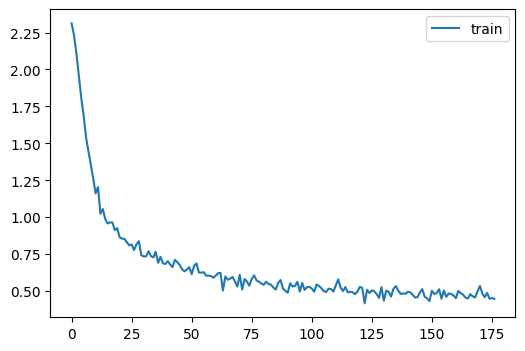

In [ ]:
learn.fit(3,lr=0.01)

In [ ]:
reseed.set_seed(42)
model = get_model_lin().apply(init_weights_zero)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.002, cbs=cbs)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=2048, bias=True, init=H2)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=2048, bias=True, init=I)
  (4): ReLU()
  (5): Linear(in_features=2048, out_features=10, bias=True, init=I)
)

In [ ]:
r = model(xb)
r.mean(), r.std()

(tensor(0.35, grad_fn=<MeanBackward0>), tensor(1.48, grad_fn=<StdBackward0>))

Using seed 42


accuracy,loss,epoch,train
0.733,0.823,0,train
0.816,0.523,0,eval
0.838,0.464,1,train
0.836,0.471,1,eval
0.852,0.423,2,train
0.845,0.442,2,eval


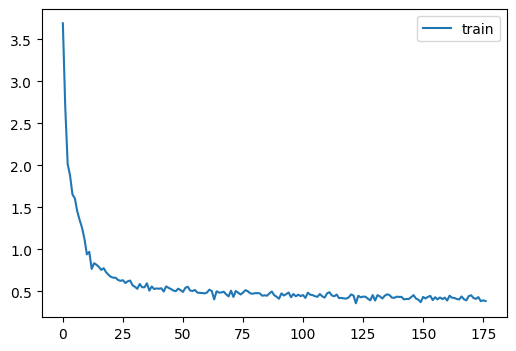

In [ ]:
learn.fit(3,lr=0.01)

## convolution

In [ ]:
xb=xb.to(def_device)

In [ ]:
reseed.set_seed(42)
model2 = get_model().to(def_device)
model2.apply(iw)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
r = model2(xb)
r.mean(), r.std()

(tensor(-0.10, device='mps:0', grad_fn=<MeanBackward0>),
 tensor(0.88, device='mps:0', grad_fn=<StdBackward0>))

In [ ]:
@torch.no_grad()
def init_hadamard_(w, c=None):
    if w.dim() == 2: 
        m,n = w.shape
        rank = math.ceil(math.log(m, 2))
        if c is None: c = 2**(-(rank-1)/2)
        H = hadamard(rank)
        w.copy_(torch.eye(m, H.shape[0]) @ H @ torch.eye(H.shape[0], n)*c) 
    elif w.dim() == 4:
        init.zeros_(w)
        n = int(w.shape[-1]/2)
        print(w.shape)
        r=math.ceil(math.log(w.shape[1],2))
        c=2**(-r/2)
        init_hadamard_(w[..., n, n], c=c)
        #w.copy_(init_hadamard_(torch.zeros(*w.shape[2:])).expand_as(w))
    return w

reseed.set_seed(42)
model = get_model(act_gr).to(def_device)
model.apply(init_weights_zero)
model

torch.Size([8, 1, 3, 3])
torch.Size([16, 8, 3, 3])
torch.Size([32, 16, 3, 3])
torch.Size([64, 32, 3, 3])


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H100)
    (1): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H35)
    (1): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H25)
    (1): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H18)
    (1): GeneralRelu()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=I)
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
if 'hooks' in globals(): hooks.remove()
def print_stats(hook, mod, inp, outp):
    inp,*_=to_cpu(inp) 
    outp = to_cpu(outp)
    print(f'inp({inp.mean():.2f}, {inp.std():.2f})>{mod}>outp({outp.mean():.2f}, {outp.std():.2f}) ')
    
hooks = Hooks(fc.filter_ex(model.modules(), partial(fc.risinstance, nn.Conv2d)), print_stats)

In [ ]:
r = model(xb)
r.mean(), r.std()

inp(0.01, 1.01)>Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H100)>outp(0.01, 1.01) 
inp(0.02, 0.71)>Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H35)>outp(-0.00, 0.69) 
inp(-0.30, 0.57)>Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H25)>outp(0.05, 0.61) 
inp(-0.26, 0.46)>Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H18)>outp(-0.09, 0.51) 
inp(-0.38, 0.34)>Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=I)>outp(-0.43, 0.07) 


(tensor(-0.43, device='mps:0', grad_fn=<MeanBackward0>),
 tensor(0.07, device='mps:0', grad_fn=<StdBackward0>))

In [ ]:
hooks.remove()

In [ ]:
if 'hooks2' in globals(): hooks2.remove()
hooks2 = Hooks(fc.filter_ex(model2.modules(), partial(fc.risinstance, nn.Conv2d)), print_stats)

In [ ]:
r2 = model2(xb)
r2.mean(), r2.std()

inp(0.01, 1.01)>Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))>outp(-0.03, 1.35) 
inp(0.52, 0.78)>Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))>outp(-0.04, 1.22) 
inp(0.42, 0.76)>Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))>outp(0.13, 1.12) 
inp(0.47, 0.75)>Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))>outp(0.05, 1.10) 
inp(0.42, 0.72)>Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))>outp(-0.10, 0.88) 


(tensor(-0.10, device='mps:0', grad_fn=<MeanBackward0>),
 tensor(0.88, device='mps:0', grad_fn=<StdBackward0>))

In [ ]:
model[0][0]

Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H35)

In [ ]:
with torch.no_grad():
    model[0][0].weight[...,1,1] =1
model[0][0].weight[...,1,1]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='mps:0', grad_fn=<SelectBackward0>)

In [ ]:
xb1=model[0](xb)

inp(0.01, 1.01)>Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H100)>outp(0.01, 1.01) 


In [ ]:
model[1]

Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H25)
  (1): ReLU()
)

In [ ]:
m=math.log(8,2)
m

3.0

In [ ]:
math.log(8, 2), math.log(7, 2), math.log(9, 2)

(3.0, 2.807354922057604, 3.1699250014423126)

In [ ]:
(8).bit_length(), (7).bit_length(), (9).bit_length()

(4, 3, 4)

In [ ]:
2**(-(m-1)/2)

0.5

In [ ]:
2**(-3/2)

0.3535533905932738

In [ ]:
2**(-4/2)

0.25

In [ ]:
math.ceil(math.log(16,2))

4

In [ ]:
math.ceil(math.log(8,2))

3

In [ ]:
with torch.no_grad():
    model[2][0].weight[...,1,1] *= 0.25/0.35 

In [ ]:
r = model(xb)
r.mean(), r.std()

inp(0.01, 1.01)>Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H100)>outp(0.01, 1.01) 
inp(0.46, 0.67)>Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H50)>outp(0.22, 1.10) 
inp(0.22, 1.10)>Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H25)>outp(0.36, 0.95) 
inp(0.36, 0.95)>Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H25)>outp(0.17, 1.37) 
inp(0.17, 1.37)>Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=I)>outp(0.00, 0.00) 


(tensor(0., device='mps:0', grad_fn=<MeanBackward0>),
 tensor(0., device='mps:0', grad_fn=<StdBackward0>))

In [ ]:
model[1][0].stride = 2,2
model[1][0]

Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H50)

In [ ]:
model[1](xb1)[0]

inp(0.46, 0.67)>Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H50)>outp(0.22, 1.10) 


tensor([[[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 2.49, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 7.24, 6.44, 2.31],
         [0.00, 0.00, 0.00, 1.24, 6.57, 6.44, 7.78],
         [0.00, 0.00, 5.27, 6.53, 6.26, 4.69, 7.24],
         [0.16, 5.45, 6.48, 5.67, 6.97, 6.57, 6.66],
         [0.00, 0.00, 7.51, 7.74, 5.36, 4.91, 1.24]],

        [[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]],

        [[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.

In [ ]:
r =model(xb)
r.mean(), r.std()

inp(0.01, 1.01)>Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H100)>outp(0.01, 1.01) 
inp(0.46, 0.67)>Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H50)>outp(0.22, 1.10) 
inp(0.22, 1.10)>Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H18)>outp(0.25, 0.66) 
inp(0.25, 0.66)>Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H13)>outp(0.06, 0.48) 
inp(0.06, 0.48)>Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=I)>outp(0.00, 0.00) 


(tensor(0., device='mps:0', grad_fn=<MeanBackward0>),
 tensor(0., device='mps:0', grad_fn=<StdBackward0>))

In [ ]:
from miniai.init_mod import LSUVInit

torch.Size([8, 1, 3, 3])
torch.Size([16, 8, 3, 3])
torch.Size([32, 16, 3, 3])
torch.Size([64, 32, 3, 3])
Using seed 42


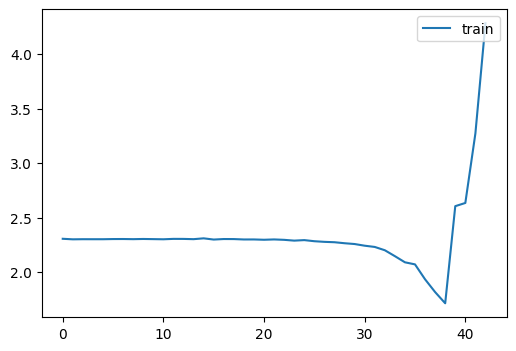

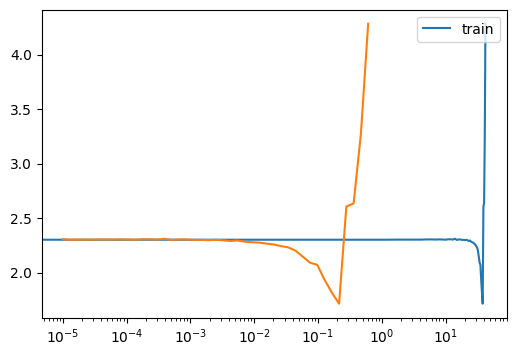

In [ ]:
model = get_model(act_gr).apply(init_weights_zero)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.lr_find()

torch.Size([8, 1, 3, 3])
torch.Size([16, 8, 3, 3])
torch.Size([32, 16, 3, 3])
torch.Size([64, 32, 3, 3])
Using seed 42


accuracy,loss,epoch,train
0.608,1.067,0,train
0.781,0.596,0,eval
0.828,0.463,1,train
0.841,0.440,1,eval
0.856,0.392,2,train
0.847,0.424,2,eval


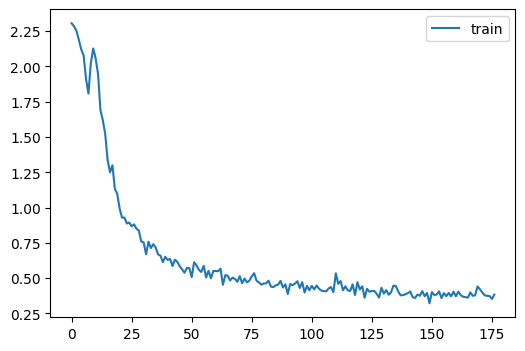

In [ ]:
model = get_model(act_gr).apply(init_weights_zero)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2 , cbs=cbs)
learn.fit(3)

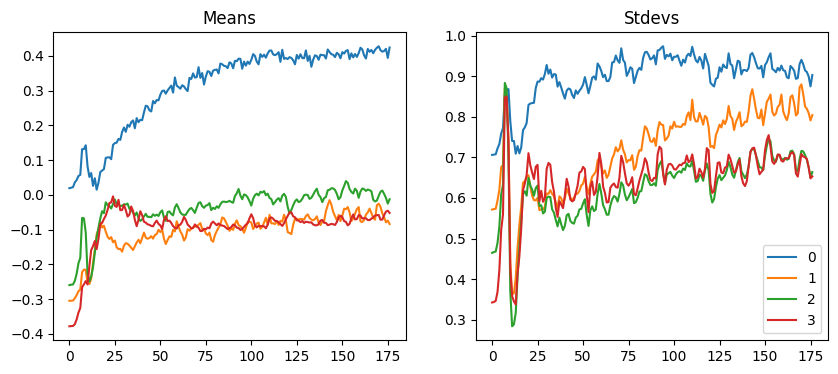

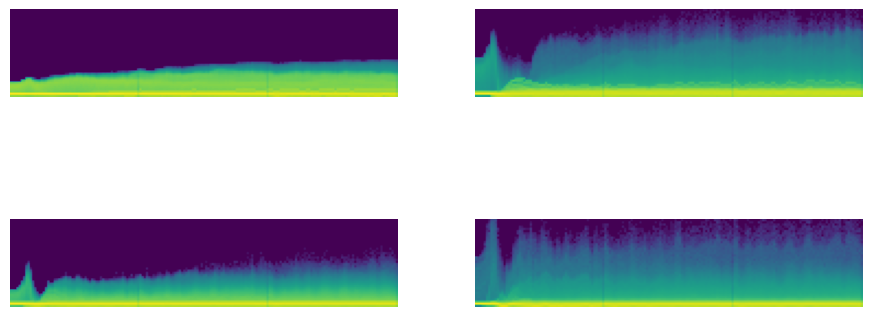

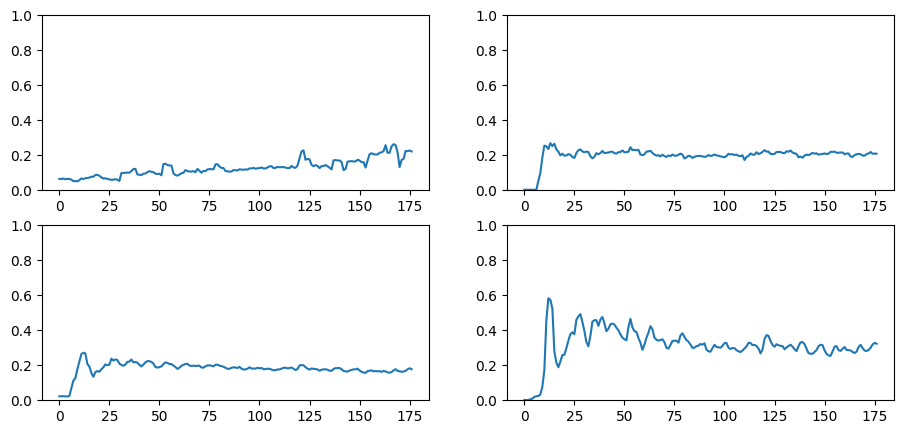

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

In [ ]:
from miniai.init_mod import lsuv_init, lsuv_layers, _lsuv_stats

In [ ]:
_lsuv_stats??

In [ ]:
def lsuv_init(model, m_act, m_in, xb, eps=1e-3, log=print, max_step=10):
    h = Hook(m_act, _lsuv_stats)
    log(f'LSUV: {m_in} {m_act if m_act!=m_in else ""}')
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>eps or abs(h.mean)>eps):
            log(f'LSUV: {h.mean} {h.std} {max_step}')
            if abs(h.mean) > eps: m_in.bias -= h.mean
            if abs(h.std-1) > eps: m_in.weight.data /= h.std
            max_step -= 1
            if max_step == 0: 
                break
        log(f'LSUV: {m_in} {h.mean} {h.std} {max_step}')
    h.remove()

In [ ]:
class LSUVInit(Callback):
    def __init__(self, layers=None, eps=1e-3, verbose=False, stop_after_init=False, skip_last=0):
        """Layers is a function that returns iterable of point of measurement and conv|linear to tweak"""
        self.layers = layers if layers is not None else lsuv_layers
        self.log = fc.noop if not verbose else print
        self.eps = eps
        self.stop_after_init = stop_after_init
        self.skip_last = -skip_last if skip_last != 0 else None
    
    def before_batch(self, learn):
        if getattr(learn.model, 'lsuv_init', False): return
        layers = list(self.layers(learn.model))
        self.log('LSUV init', layers)
        xb,_ = learn.batch
        training  = learn.model.training
        learn.model.train(False)
        with torch.no_grad():    
            for ms in layers[:self.skip_last]: 
                lsuv_init(learn.model, *ms, xb, eps=self.eps, log=self.log)
        learn.model.lsuv_init = True
        learn.model.train(training)
        print(f'LSUV init done on {len(layers)} layers')
        if self.stop_after_init: raise CancelFitException()

In [ ]:
from miniai.init_mod import orthogonal_init

torch.Size([8, 1, 3, 3])
torch.Size([16, 8, 3, 3])
torch.Size([32, 16, 3, 3])
torch.Size([64, 32, 3, 3])
Using seed 42


accuracy,loss,epoch,train
0.780,0.616,0,train
0.844,0.435,0,eval
0.862,0.381,1,train
0.861,0.391,1,eval
0.877,0.341,2,train
0.869,0.368,2,eval


LSUV init [(Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H22), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H22)), (Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=?), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=?)), (Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=?), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=?)), (Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=?), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=?)), (Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H4), Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H4))]
LSUV: Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H22) 
LSUV: 0.01647665537893772 1.2772287130355835 10
LSUV: Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H17) -0.00357632711529731

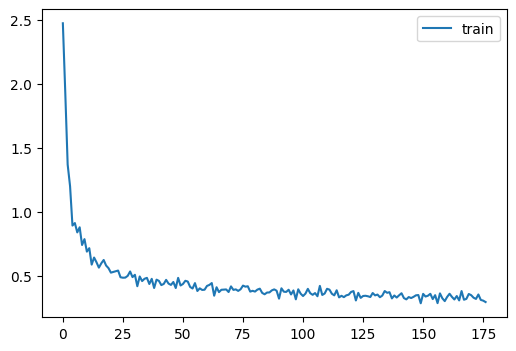

In [ ]:
set_seed(42)
model = get_model(act_gr).apply(init_weights_zero).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.1 , cbs=cbs)
learn.fit(3, cbs=LSUVInit(verbose=True, stop_after_init=False, eps=0.01, skip_last=0))

In [ ]:

# experiments with different initialisations. 

# [zerto bias]
# iw all (rand bias) 0.862 (0.859)
# iw all +lsuv (rand bias) 0.869, 0.859 
# oth_n(_paper) +lsuv 0.854, 0.858
# torch +lsuv 0.859


# experiments with init_weights_zero + lsuv + different init of the last layer
#iw(learn.model[-2])#0.846 (vs 0.837)
#nn.init.ones_(learn.model[-2].weight) # 0.799
#init_hadamard_(learn.model[-2].weight) # 0.814
#learn.model[-2].weight.shape

Using seed 42


accuracy,loss,epoch,train
0.754,0.688,0,train
0.831,0.465,0,eval
0.852,0.405,1,train
0.844,0.423,1,eval
0.869,0.360,2,train
0.853,0.396,2,eval


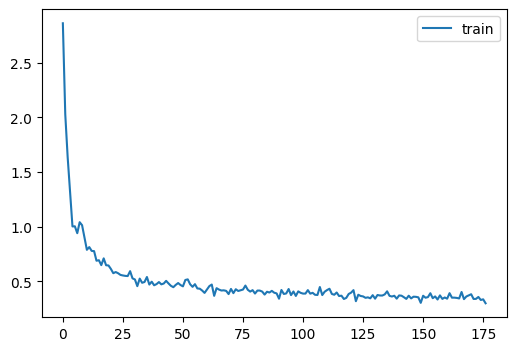

In [ ]:
learn.fit(3)

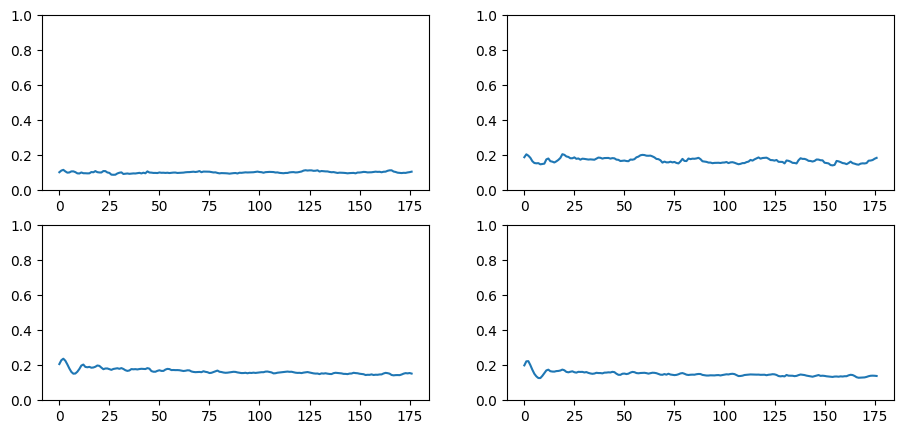

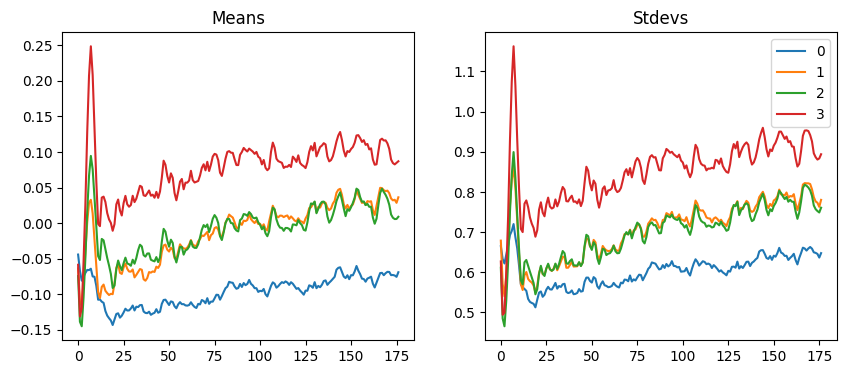

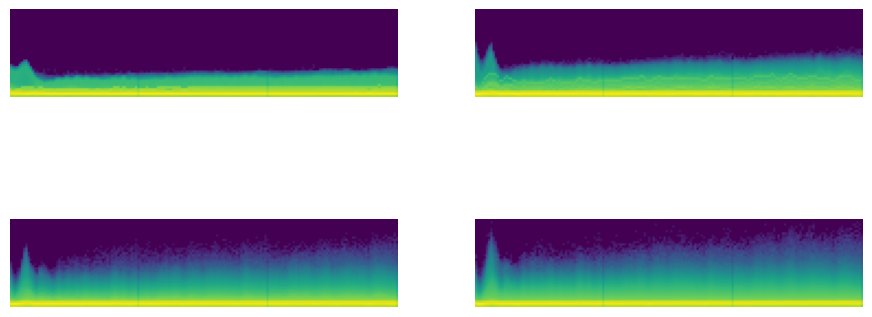

In [ ]:
astats.dead_chart();astats.plot_stats();astats.color_dim()

Using seed 42


accuracy,loss,epoch,train
0.394,1.718,0,train
0.584,1.155,0,eval
0.656,0.962,1,train
0.697,0.881,1,eval
0.703,0.830,2,train
0.723,0.793,2,eval


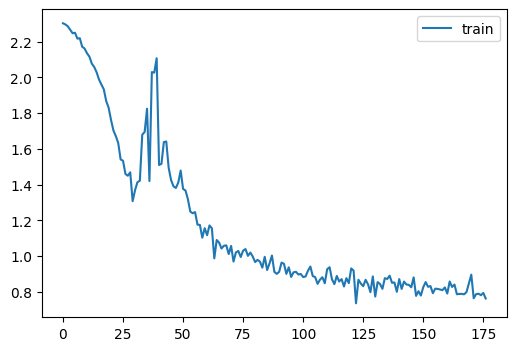

In [ ]:
learn.fit(3, lr=0.01 )

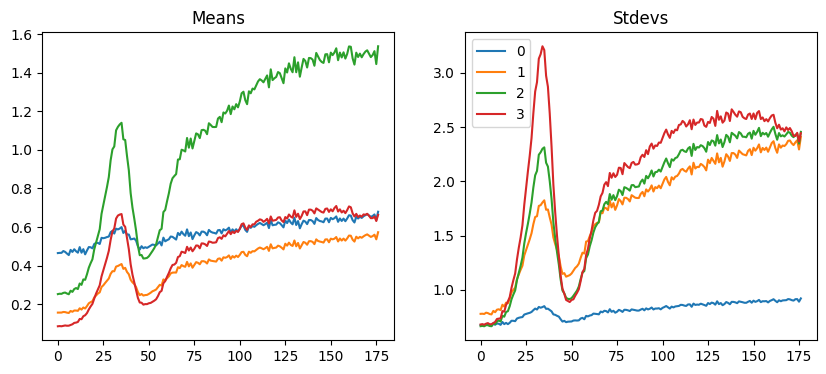

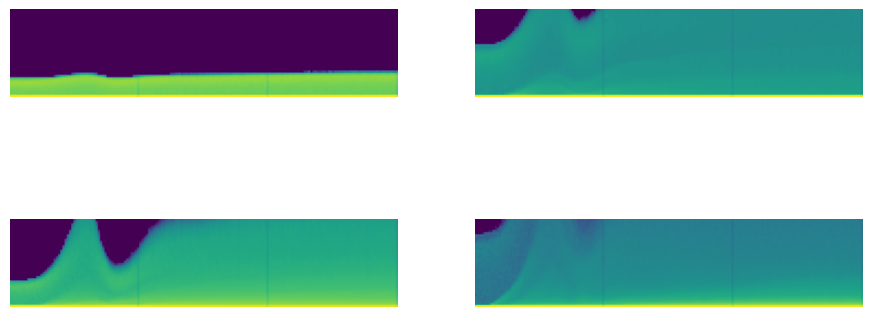

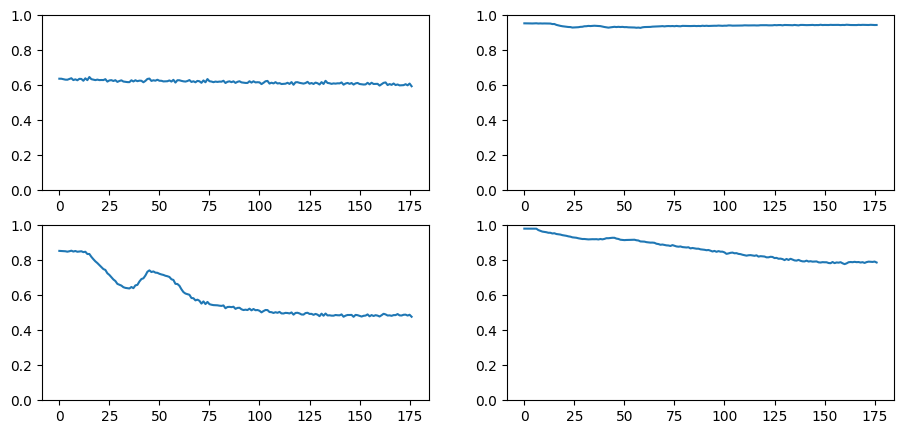

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

### conv with one cycle

torch.Size([8, 1, 3, 3])
torch.Size([16, 8, 3, 3])
torch.Size([32, 16, 3, 3])
torch.Size([64, 32, 3, 3])
Using seed 42


accuracy,loss,epoch,train
0.564,1.178,0,train
0.776,0.635,0,eval
0.820,0.499,1,train
0.838,0.447,1,eval
0.856,0.399,2,train
0.849,0.419,2,eval


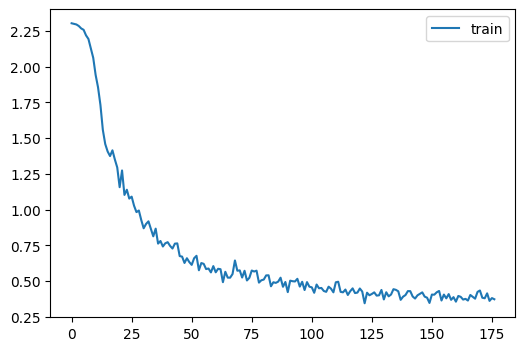

In [ ]:
model = get_model().apply(init_weights_zero)
epochs = 3
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

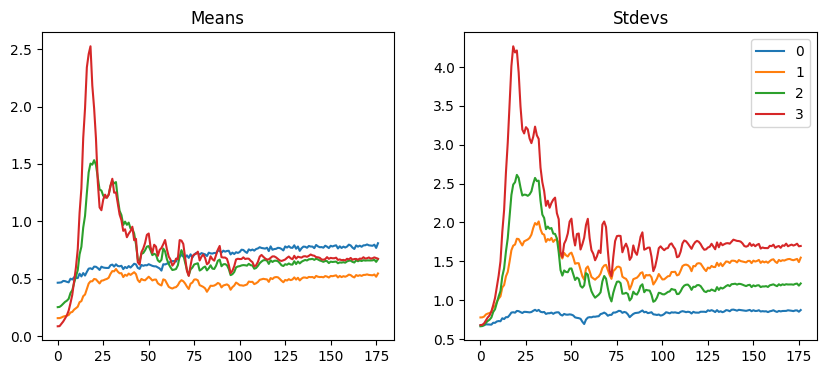

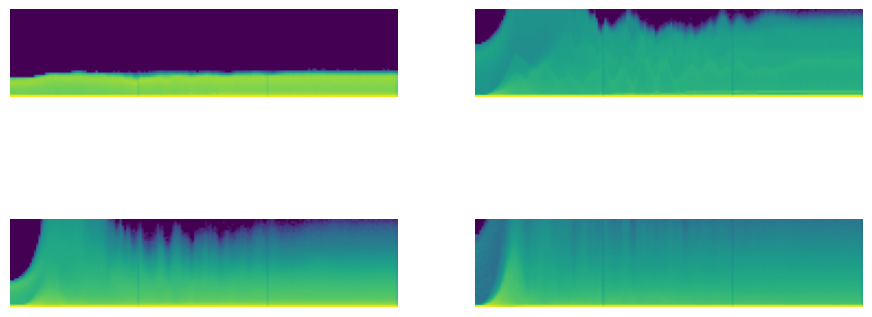

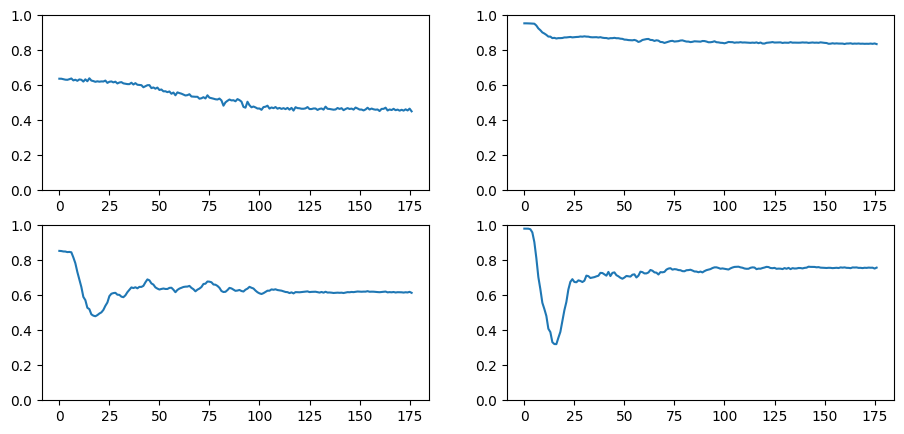

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

torch.Size([8, 1, 3, 3])
torch.Size([16, 8, 3, 3])
torch.Size([32, 16, 3, 3])
torch.Size([64, 32, 3, 3])
Using seed 42


accuracy,loss,epoch,train
0.568,1.194,0,train
0.769,0.598,0,eval
0.836,0.449,1,train
0.846,0.415,1,eval
0.872,0.347,2,train
0.863,0.368,2,eval


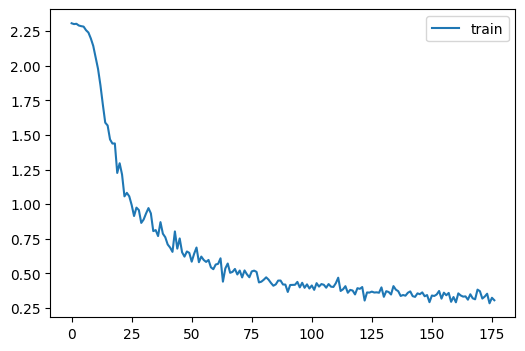

In [ ]:
model = get_model(act_gr).apply(init_weights_zero)
epochs = 3
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Using seed 42


accuracy,loss,epoch,train
0.330,1.906,0,train
0.612,1.120,0,eval
0.713,0.791,1,train
0.768,0.645,1,eval
0.796,0.550,2,train
0.813,0.521,2,eval
0.837,0.445,3,train
0.839,0.456,3,eval
0.857,0.391,4,train
0.857,0.394,4,eval


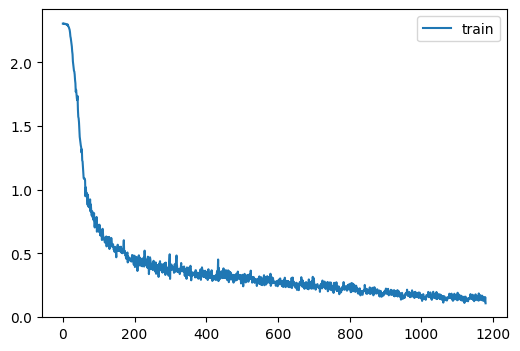

In [ ]:
model = get_model(act_gr).apply(init_weights_zero)
epochs = 20
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

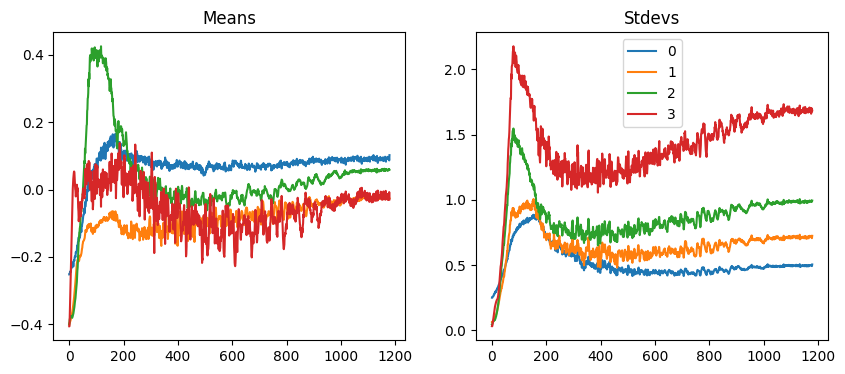

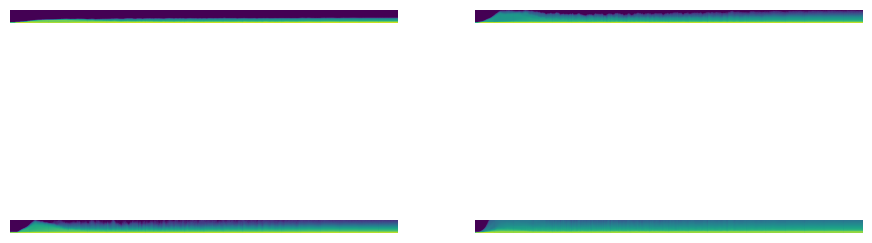

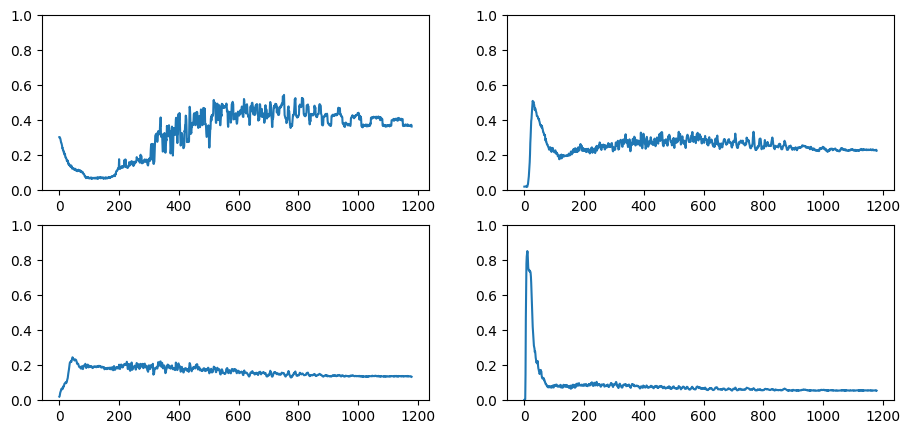

In [ ]:
astats.plot_stats();astats.color_dim();astats.dead_chart()

Using seed 42


accuracy,loss,epoch,train
0.680,0.970,0,train
0.802,0.549,0,eval
0.839,0.446,1,train
0.846,0.433,1,eval
0.865,0.370,2,train
0.868,0.380,2,eval
0.880,0.332,3,train
0.875,0.352,3,eval
0.888,0.306,4,train
0.879,0.349,4,eval


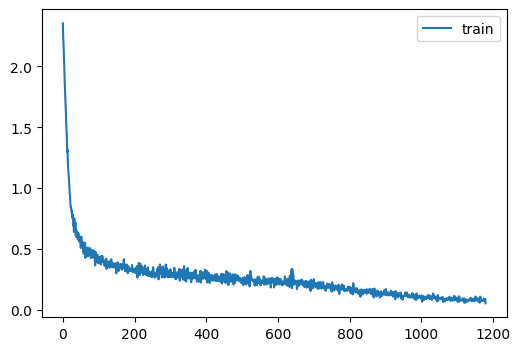

In [ ]:
model = get_model(act_gr).apply(iw)
epochs = 20
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

### Resnet

In [ ]:
set_seed(42)
def get_model_res(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)




In [ ]:
def init_weights_zero_resnet(m):
    if isinstance(m, ResBlock):
        m.apply(init_weights_zero)
        nn.init.zeros_(m.convs[-1][0].weight)
    if isinstance(m, nn.Linear):
        m.apply(init_weights_zero)

In [ ]:
model = get_model_res(act_gr, norm=nn.BatchNorm2d)
model.apply(init_weights_zero_resnet)

Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), init=H35)
        (1): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), init=H0)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), init=H35)
    )
    (act): GeneralRelu()
  )
  (1): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), init=H25)
        (1): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), init=H0)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), init=H25)
    )
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (act): GeneralRelu()
  )
  (2): ResBlock(
    (convs): Sequential(
    

Using seed 42


accuracy,loss,epoch,train
0.650,1.024,0,train
0.100,2.434,0,eval


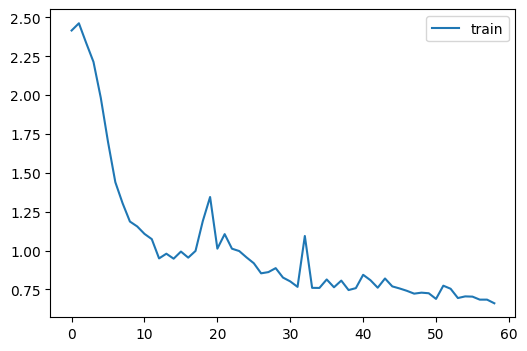

In [ ]:
lr = 2e-3
model.apply(init_weights_zero_resnet)
tmax = 2 * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=optim.AdamW)
learn.fit(1)

Using seed 42


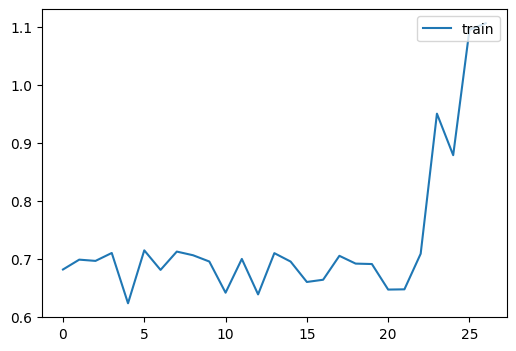

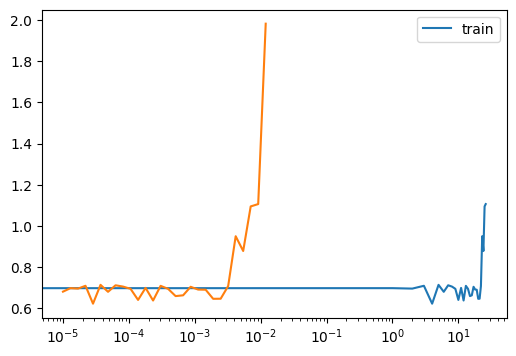

In [ ]:
learn.lr_find()

Using seed 42


accuracy,loss,epoch,train
0.453,1.607,0,train
0.661,1.076,0,eval
0.803,0.710,1,train
0.820,0.554,1,eval
0.564,1.313,2,train
0.252,1.770,2,eval
0.550,1.250,3,train
0.618,1.208,3,eval
0.640,1.040,4,train
0.641,1.041,4,eval


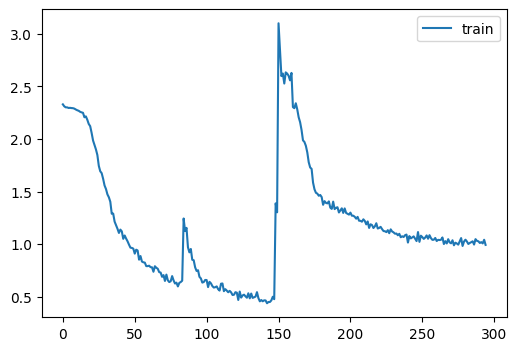

In [ ]:
epochs = 5
lr = 4e-3
model = get_model_res(act_gr, norm=nn.BatchNorm2d)
model.apply(init_weights_zero)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Using seed 42


accuracy,loss,epoch,train
0.492,1.636,0,train
0.100,inf,0,eval
0.442,1.624,1,train
0.354,1.803,1,eval
0.618,1.101,2,train
0.444,1.566,2,eval
0.706,0.834,3,train
0.685,0.871,3,eval
0.735,0.744,4,train
0.726,0.758,4,eval


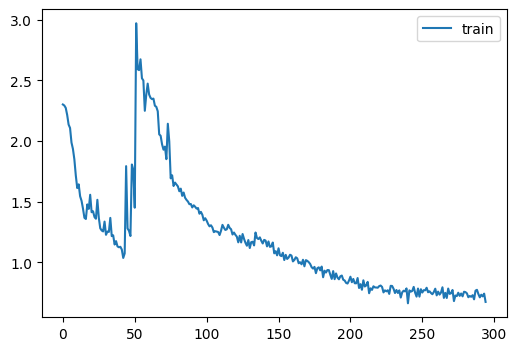

In [ ]:
epochs = 5
lr = 2e-2
model = get_model_res(act_gr, norm=nn.BatchNorm2d)
model.apply(init_weights_zero_resnet)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Using seed 42
Adjusting learning rate of group 0 to 4.0000e-04.


accuracy,loss,epoch,train
0.382,1.836,0,train
0.396,1.482,0,eval
0.639,1.041,1,train
0.461,1.295,1,eval
0.727,0.755,2,train
0.726,0.765,2,eval
0.757,0.668,3,train
0.751,0.689,3,eval
0.767,0.641,4,train
0.762,0.662,4,eval


Adjusting learning rate of group 0 to 4.5948e-04.


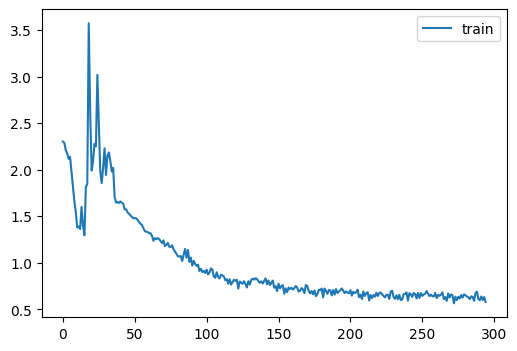

Adjusting learning rate of group 0 to 6.3720e-04.
Adjusting learning rate of group 0 to 9.3099e-04.
Adjusting learning rate of group 0 to 1.3373e-03.
Adjusting learning rate of group 0 to 1.8512e-03.
Adjusting learning rate of group 0 to 2.4664e-03.
Adjusting learning rate of group 0 to 3.1755e-03.
Adjusting learning rate of group 0 to 3.9699e-03.
Adjusting learning rate of group 0 to 4.8399e-03.
Adjusting learning rate of group 0 to 5.7750e-03.
Adjusting learning rate of group 0 to 6.7638e-03.
Adjusting learning rate of group 0 to 7.7942e-03.
Adjusting learning rate of group 0 to 8.8539e-03.
Adjusting learning rate of group 0 to 9.9300e-03.
Adjusting learning rate of group 0 to 1.1009e-02.
Adjusting learning rate of group 0 to 1.2079e-02.
Adjusting learning rate of group 0 to 1.3125e-02.
Adjusting learning rate of group 0 to 1.4137e-02.
Adjusting learning rate of group 0 to 1.5100e-02.
Adjusting learning rate of group 0 to 1.6004e-02.
Adjusting learning rate of group 0 to 1.6837e-02.


Adjusting learning rate of group 0 to 9.4467e-03.
Adjusting learning rate of group 0 to 9.3287e-03.
Adjusting learning rate of group 0 to 9.2108e-03.
Adjusting learning rate of group 0 to 9.0930e-03.
Adjusting learning rate of group 0 to 8.9753e-03.
Adjusting learning rate of group 0 to 8.8578e-03.
Adjusting learning rate of group 0 to 8.7404e-03.
Adjusting learning rate of group 0 to 8.6232e-03.
Adjusting learning rate of group 0 to 8.5062e-03.
Adjusting learning rate of group 0 to 8.3895e-03.
Adjusting learning rate of group 0 to 8.2729e-03.
Adjusting learning rate of group 0 to 8.1566e-03.
Adjusting learning rate of group 0 to 8.0405e-03.
Adjusting learning rate of group 0 to 7.9248e-03.
Adjusting learning rate of group 0 to 7.8093e-03.
Adjusting learning rate of group 0 to 7.6941e-03.
Adjusting learning rate of group 0 to 7.5792e-03.
Adjusting learning rate of group 0 to 7.4647e-03.
Adjusting learning rate of group 0 to 7.3506e-03.
Adjusting learning rate of group 0 to 7.2368e-03.


In [ ]:
epochs = 5
lr = 2e-2
model = get_model_res(act_gr, norm=nn.BatchNorm2d)
model.apply(init_weights_zero_resnet)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.1, div_factor=50, final_div_factor=25, verbose=True)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

### resnet with ReZero architecture

In [ ]:
class Re0ResBlock(ResBlock):
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.alpha=nn.Parameter(torch.tensor([0.]))
    def forward(self, x): return self.alpha*self.act(self.convs(x)) + self.idconv(self.pool(x))
        

In [ ]:
set_seed(42)
def get_model_re0(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [Re0ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [Re0ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

model = get_model_re0(act_gr, norm=None)

Using seed 42


accuracy,loss,epoch,train
0.517,1.633,0,train
0.729,0.751,0,eval
0.834,0.523,1,train
0.838,0.456,1,eval
0.877,0.357,2,train
0.867,0.366,2,eval
0.901,0.284,3,train
0.899,0.298,3,eval
0.916,0.242,4,train
0.904,0.279,4,eval


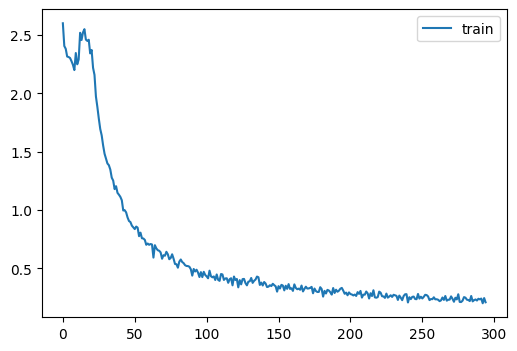

In [ ]:
epochs = 5
lr = 2e-2
model = get_model_re0(act_gr, norm=None).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Using seed 42


accuracy,loss,epoch,train
0.310,2.361,0,train
0.501,1.454,0,eval
0.706,1.030,1,train
0.749,0.859,1,eval
0.813,0.693,2,train
0.821,0.641,2,eval
0.844,0.587,3,train
0.839,0.598,3,eval
0.855,0.549,4,train
0.843,0.571,4,eval


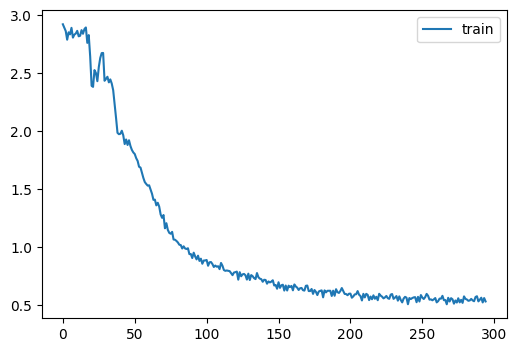

In [ ]:
epochs = 5
lr = 2e-3
model = get_model_re0(act_gr, norm=None).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Using seed 42


accuracy,loss,epoch,train
0.570,1.340,0,train
0.725,0.802,0,eval
0.834,0.502,1,train
0.832,0.466,1,eval
0.879,0.345,2,train
0.879,0.344,2,eval
0.903,0.277,3,train
0.898,0.289,3,eval
0.919,0.232,4,train
0.908,0.264,4,eval


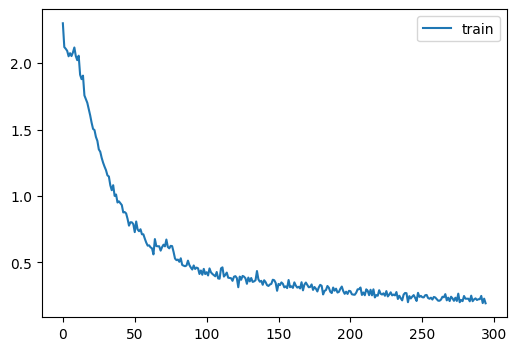

In [ ]:
epochs = 5
lr = 2e-2
model = get_model_re0(act_gr, norm=None).apply(init_weights_zero)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Using seed 42
Adjusting learning rate of group 0 to 8.0000e-04.


accuracy,loss,epoch,train
0.640,1.106,0,train
0.770,0.643,0,eval
0.853,0.430,1,train
0.826,0.471,1,eval
0.886,0.326,2,train
0.884,0.331,2,eval
0.907,0.266,3,train
0.900,0.282,3,eval
0.921,0.230,4,train
0.908,0.263,4,eval


Adjusting learning rate of group 0 to 8.5827e-04.


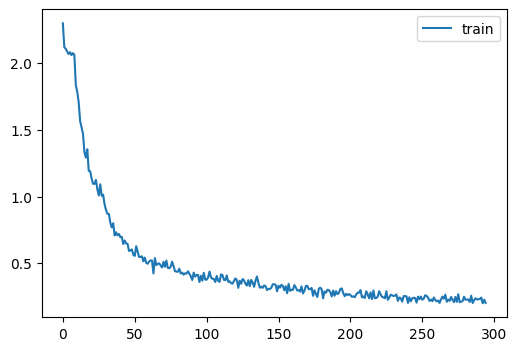

Adjusting learning rate of group 0 to 1.0324e-03.
Adjusting learning rate of group 0 to 1.3202e-03.
Adjusting learning rate of group 0 to 1.7182e-03.
Adjusting learning rate of group 0 to 2.2216e-03.
Adjusting learning rate of group 0 to 2.8243e-03.
Adjusting learning rate of group 0 to 3.5189e-03.
Adjusting learning rate of group 0 to 4.2971e-03.
Adjusting learning rate of group 0 to 5.1493e-03.
Adjusting learning rate of group 0 to 6.0653e-03.
Adjusting learning rate of group 0 to 7.0339e-03.
Adjusting learning rate of group 0 to 8.0433e-03.
Adjusting learning rate of group 0 to 9.0814e-03.
Adjusting learning rate of group 0 to 1.0135e-02.
Adjusting learning rate of group 0 to 1.1193e-02.
Adjusting learning rate of group 0 to 1.2240e-02.
Adjusting learning rate of group 0 to 1.3266e-02.
Adjusting learning rate of group 0 to 1.4256e-02.
Adjusting learning rate of group 0 to 1.5200e-02.
Adjusting learning rate of group 0 to 1.6085e-02.
Adjusting learning rate of group 0 to 1.6902e-02.


Adjusting learning rate of group 0 to 9.4551e-03.
Adjusting learning rate of group 0 to 9.3372e-03.
Adjusting learning rate of group 0 to 9.2194e-03.
Adjusting learning rate of group 0 to 9.1017e-03.
Adjusting learning rate of group 0 to 8.9841e-03.
Adjusting learning rate of group 0 to 8.8667e-03.
Adjusting learning rate of group 0 to 8.7494e-03.
Adjusting learning rate of group 0 to 8.6323e-03.
Adjusting learning rate of group 0 to 8.5154e-03.
Adjusting learning rate of group 0 to 8.3988e-03.
Adjusting learning rate of group 0 to 8.2823e-03.
Adjusting learning rate of group 0 to 8.1661e-03.
Adjusting learning rate of group 0 to 8.0501e-03.
Adjusting learning rate of group 0 to 7.9344e-03.
Adjusting learning rate of group 0 to 7.8190e-03.
Adjusting learning rate of group 0 to 7.7040e-03.
Adjusting learning rate of group 0 to 7.5892e-03.
Adjusting learning rate of group 0 to 7.4748e-03.
Adjusting learning rate of group 0 to 7.3607e-03.
Adjusting learning rate of group 0 to 7.2470e-03.


In [ ]:
epochs = 5
lr = 2e-2
model = get_model_re0(act_gr, norm=None).apply(init_weights_zero)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax, pct_start=0.1, div_factor=25, final_div_factor=25, verbose=True)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Using seed 42


accuracy,loss,epoch,train
0.364,1.836,0,train
0.505,1.488,0,eval
0.758,0.850,1,train
0.796,0.702,1,eval
0.836,0.596,2,train
0.829,0.593,2,eval
0.860,0.508,3,train
0.854,0.510,3,eval
0.869,0.476,4,train
0.860,0.495,4,eval


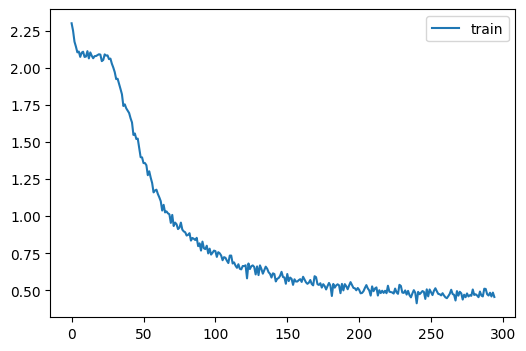

In [ ]:
epochs = 5
lr = 2e-3
model = get_model_re0(act_gr, norm=None).apply(iw)
model.apply(init_weights_zero)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
xtra[0].schedo._schedule_phases

[{'end_step': 87.5,
  'start_lr': 'initial_lr',
  'end_lr': 'max_lr',
  'start_momentum': 'max_momentum',
  'end_momentum': 'base_momentum'},
 {'end_step': 294,
  'start_lr': 'max_lr',
  'end_lr': 'min_lr',
  'start_momentum': 'base_momentum',
  'end_momentum': 'max_momentum'}]

In [ ]:
learn.opt.param_groups[0]['initial_lr'], learn.opt.param_groups[0]['max_lr'],learn.opt.param_groups[0]['min_lr'] 

(8e-05, 0.002, 8e-09)

astats.plot_stats();astats.color_dim();astats.dead_chart()

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()